# All kinds of network things 

In [29]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
from os import listdir
from os.path import isfile, join
import json 
# get files in directory 
onlyfiles = [f for f in listdir("wiki_content") if isfile(join("wiki_content", f))]

In [30]:
''' Extract links '''
theo_dict  = {}
for file in onlyfiles:
    with open(f'wiki_content/{file}','r', encoding = 'utf-8') as f:
        txt = f.read()
        links = re.findall('\[\[(.*?)(?:\|.*?)?]]', txt)
        name = file.split('.txt')[0].replace('_',' ')
        theo_dict.update({name:links}) 

In [31]:
''' Hvordan linker de til hinanden '''
# Sætter .replace('_', ' ') på name, for at have styr på fx 'Anselm_Strauss' links 
link_dict = {theorist:[_name.replace('_', ' ') for _name in links if _name.replace('_', ' ') in theo_dict.keys()]\
             for theorist, links in theo_dict.items()}

''' Link list '''
link_list = [(node_a, node_b) for node_a, nodes in link_dict.items() for node_b in nodes]

In [61]:
seen = []
repeated = []
for l in [socs, anths, ecos, psys, pols]:
    for i in l:
        if i in seen:
            repeated.append(i)
        else:
            seen.append(i)

In [33]:
''' Get science attribute '''

with open('science_name_dict.json', 'r', encoding = 'utf-8') as f: 
    science_dict = json.load(f)
    
''' Get those that are in multiple scientific field lists - Marx is in both... '''

socs = set(science_dict['soc'])
anths = set(science_dict['anth'])
ecos = set(science_dict['eco'])
psys = set(science_dict['psy'])
pols = set(science_dict['pol'])

seen = []
repeated = []
for l in [socs, anths, ecos, psys, pols]:
    for i in l:
        if i in seen:
            repeated.append([i])
        else:
            seen.append([i])

''' Inverse the dict '''
inv_science_dict = {name:science for science, names in science_dict.items() for name in names}
''' change the scientific field to "both" if they are both in the soc and anth list '''
inv_science_dict = {name:('multiple' if name in repeated else sci)\
                    for name, sci in inv_science_dict.items()}

# Match keys to link_dict --> when importing link_dict, 'Anselm_Strauss' becomes 'Anselm Strauss'
# but in the inv_science_dict he is 'Anselm_Strauss'. So it is a mess without it   
inv_science_dict = {key.replace('_', ' '):val for key, val in inv_science_dict.items()}

In [40]:
''' Make network '''
import networkx as nx
import netwulf as nw
G = nx.DiGraph()
G.add_nodes_from(link_dict.keys())
G.add_edges_from(link_list)
nx.set_node_attributes(G, inv_science_dict, name = 'group') # node attributes 

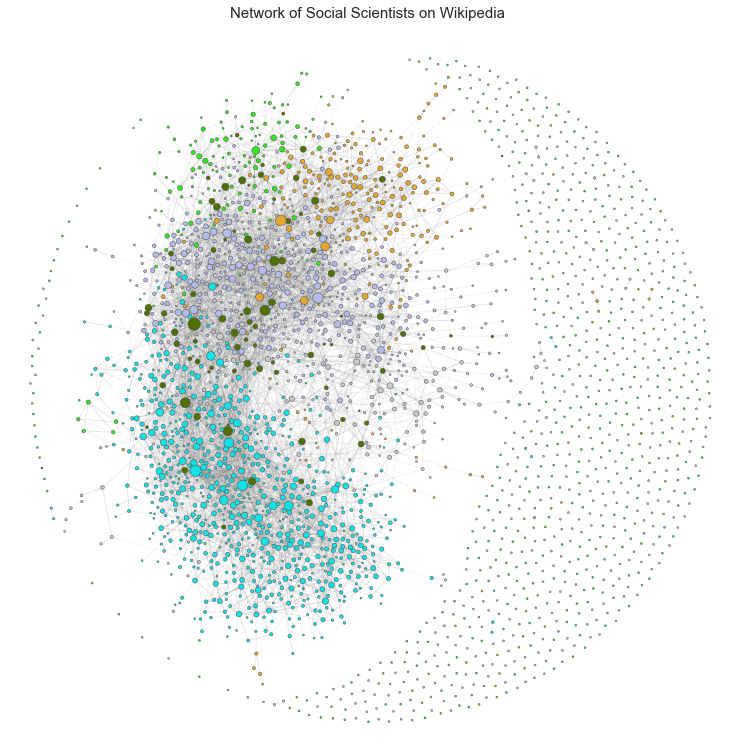

In [45]:
''' Plot network '''
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

network, config = nw.visualize(G, plot_in_cell_below=False)
fig, ax = nw.draw_netwulf(network, figsize = 10)
plt.title('Network of Social Scientists on Wikipedia', size = 15)
plt.show()

In [46]:
''' Degree distribution '''
def plot_deg_dist(deg_seq, title = 'Degree distribution', kwgs = {}):
    plt.style.use('ggplot')
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[0], **kwgs)
    ax[0].set_title(title)
    ax[0].set_ylabel('Frequency', size = 15)
    
    del deg_seq[0] # messes up the log plot so remove 0 deg nodes 
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[1], **kwgs)

    ax[1].set_title(title + ' (log scaled)')
    ax[1].set_ylabel('Frequency', size = 15)
    ax[1].set_xlabel('k', size = 15)
    # logscale the axes
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    plt.show()

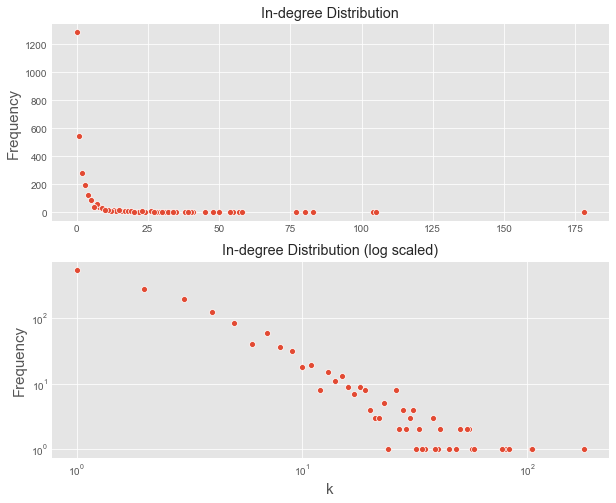

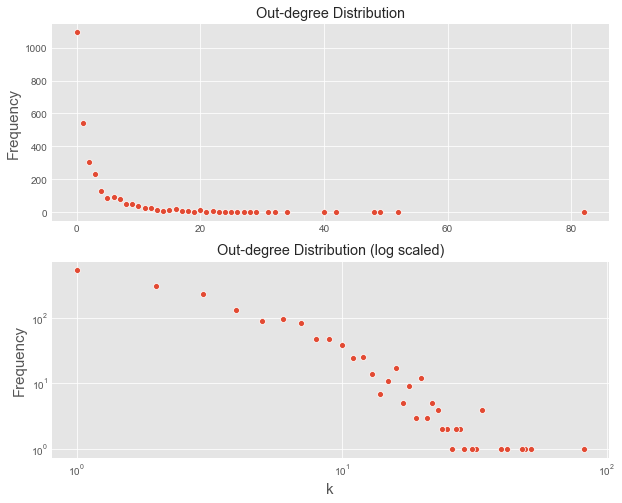

In [48]:
''' Plot degree distribution '''
import seaborn as sns
from collections import Counter

# Get in and out degree
in_deg_dist = Counter([d for n,d in G.in_degree()])
out_deg_dist = Counter([d for n,d in G.out_degree()])

plot_deg_dist(in_deg_dist, 'In-degree Distribution')
plot_deg_dist(out_deg_dist, 'Out-degree Distribution')

In [49]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(top_n = 50, in_deg = True):
    if in_deg:
        top_nodes = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    else:
        top_nodes = sorted(dict(G.out_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    x = [_[0] for _ in top_nodes]
    y = [_[1] for _ in top_nodes]

    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(x,y, ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    if in_deg:
        ax.set_title(f'Distribution of in-degree for top {top_n}', size = 15)
    else:
        ax.set_title(f'Distribution of out-degree for top {top_n}', size = 15)
    plt.show()

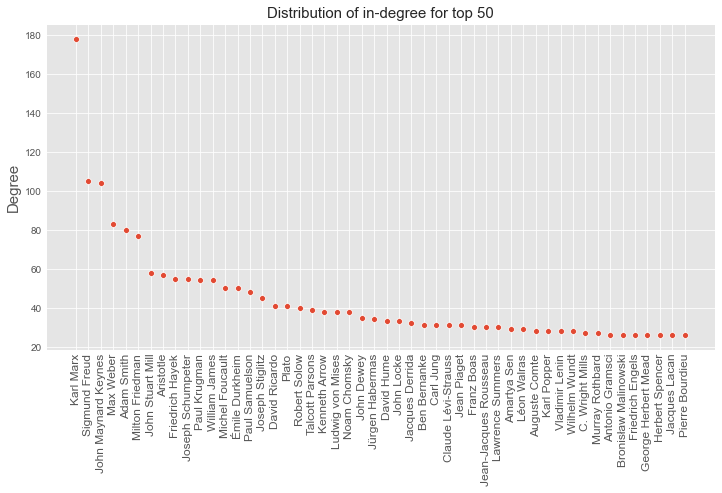

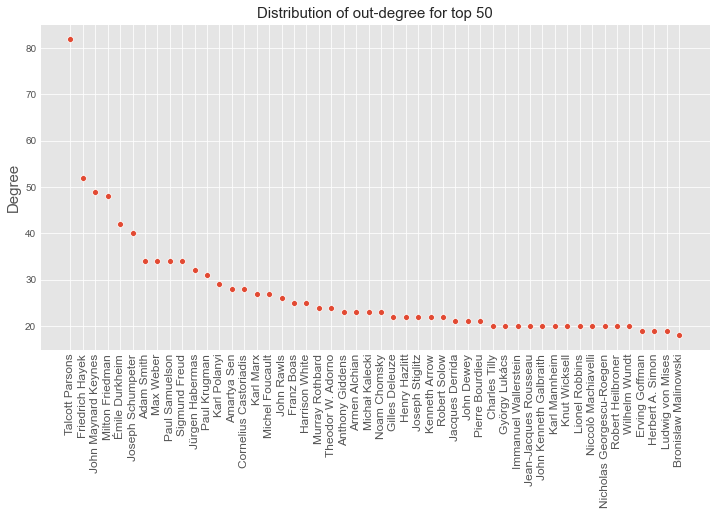

In [50]:
plot_top_nodes(in_deg = True)
plot_top_nodes(in_deg = False)

# Communities 

In [51]:
import community
from fa2 import ForceAtlas2

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.93it/s]


BarnesHut Approximation  took  7.64  seconds
Repulsion forces  took  43.16  seconds
Gravitational forces  took  0.13  seconds
Attraction forces  took  0.09  seconds
AdjustSpeedAndApplyForces step  took  0.62  seconds


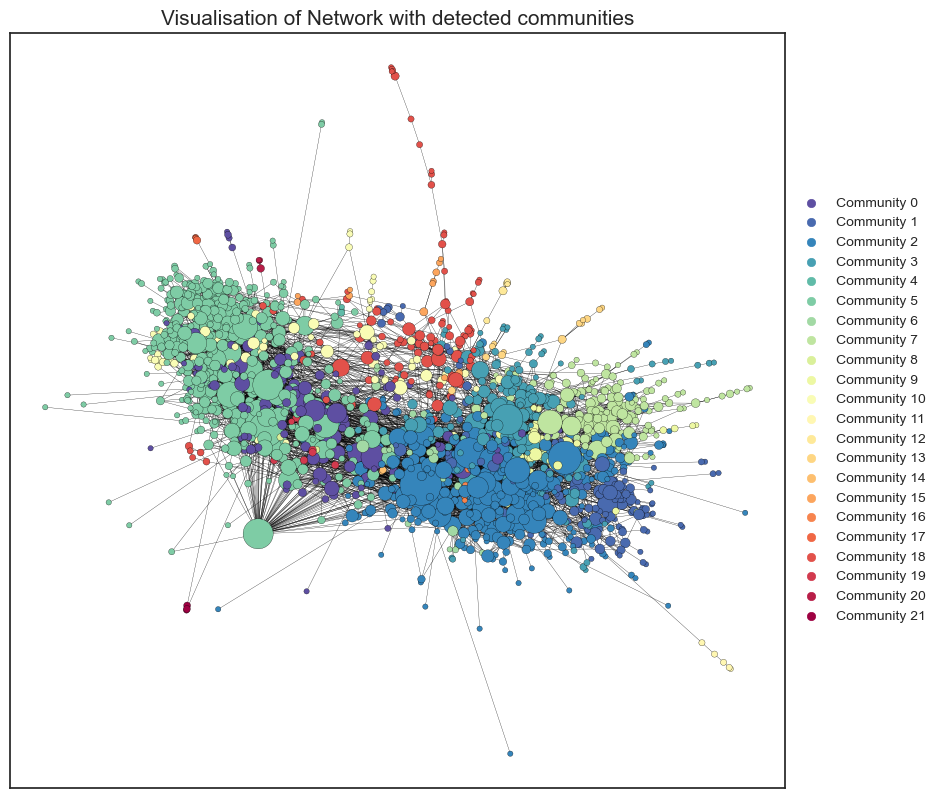

In [56]:
''' Only the GCC, otherwise there will be about 300+ communities '''
G_test = G.copy()
c = max(nx.weakly_connected_components(G_test), key=len) # largest connected component
GCC = G_test.subgraph(c).copy() # make subgraph of the largest connected component
G_undir = GCC.to_undirected().copy() # undirected

plt.style.use('seaborn-white')
# Get forceatlas positions
_pos = ForceAtlas2(outboundAttractionDistribution=True,
                   gravity=0.1,
                   verbose=True)\
       .forceatlas2_networkx_layout(G_undir, pos=None, iterations=1000)

# Louvain modularity for partition
partition = community.best_partition(G_undir)

# Get colors - use the value of the community 
c_values = list(partition.values())
# degree dict - scale node size
_d = dict(G_undir.degree) 

fig, ax = plt.subplots(dpi = 100, figsize = (10,10))

# Plot parameteres
_ks = {"node_color":c_values,
       "cmap": plt.cm.Spectral_r,
       "node_size":[10 + v*5 for v in _d.values()],
       "pos":_pos,
       "ax":ax,
       "with_labels":False,
       "edgecolors": 'black',
       "linewidths": 0.2,
       "width":0.2
       }

ax.set_title('Visualisation of Network with detected communities', size = 15)
# Set community legend
for v in set(c_values):
    plt.scatter([],[], c=[plt.cm.Spectral_r(v/max(c_values))], label='Community {}'.format(v))
    
# Place legend
plt.legend(bbox_to_anchor = (1,0.8))

nx.draw_networkx(G_undir, **_ks)
plt.show()

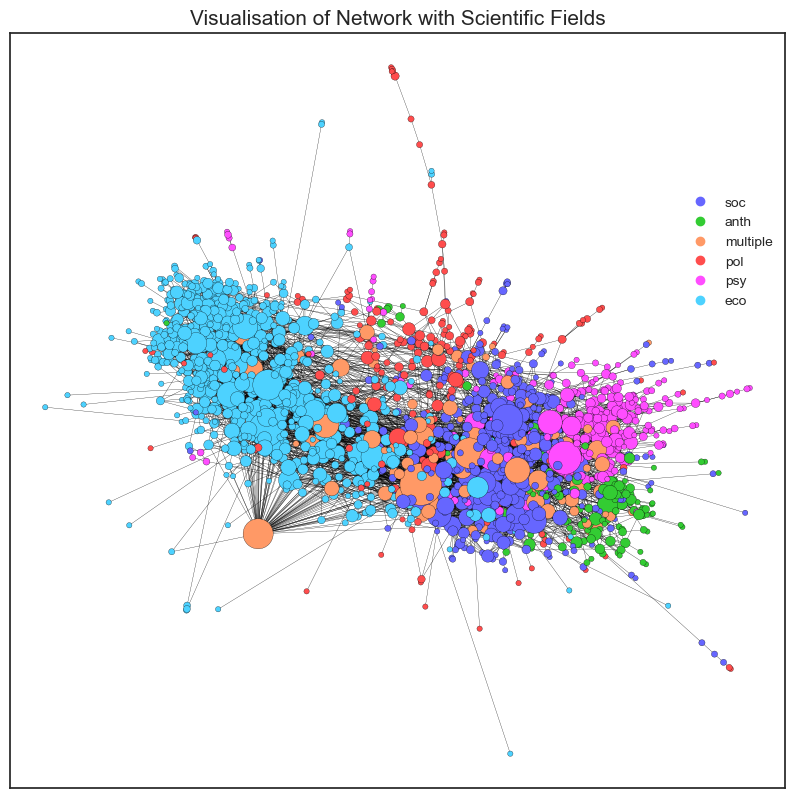

In [57]:
_field_plt()

In [54]:
def _field_plt():
    plt.style.use('seaborn-white')
    val_map = {'soc':"#6666ff",
               'anth':"#33cc33",
               'multiple':"#ff9966",
               'pol':"#ff4d4d",
               'psy': '#ff4dff',
               'eco': '#4dd2ff'}

    # Get colors - use the value of the community 
    c_values = [val_map[inv_science_dict[n]] for n in G_undir.nodes()]

    list(partition.values())
    # degree dict - scale node size
    _d = dict(G_undir.degree) 

    fig, ax = plt.subplots(dpi = 100, figsize = (10,10))

    # Plot parameteres
    _ks = {"node_color":c_values,
           "cmap": plt.cm.Spectral_r,
           "node_size":[10 + v*5 for v in _d.values()],
           "pos":_pos,
           "ax":ax,
           "with_labels":False,
           "edgecolors": 'black',
           "linewidths": 0.2,
           "width":0.2
           }

    ax.set_title('Visualisation of Network with Scientific Fields', size = 15)

    # Add legends
    for label in val_map.keys():
        ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None")

    # Place legend
    plt.legend(bbox_to_anchor = (1,0.8))

    nx.draw_networkx(G_undir, **_ks)
    plt.show()

prøv https://github.com/beyondbeneath/bezier-curved-edges-networkx